In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [3]:
from glob2 import glob
from sklearn.metrics import confusion_matrix
from fastai.metrics import error_rate
import re
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
from fastai.vision import *
import os
import shutil
import zipfile as zf

In [4]:
files = zf.ZipFile("/content/gdrive/MyDrive/Capstone/Image Classifier/csp.zip",'r')
files.extractall()
files.close()

In [5]:
class TrainTestValidate: 

  def splitDataset( self, directory ,seed1, seed2 ):    
    n = len( os.listdir( directory ) )
    
    completeDataset = []
    for i in range( 1, n+1 ):
      completeDataset.append( i )

    random.seed( seed1 )
    trainDataset = random.sample( completeDataset, int( 0.5 * n ) )

    restDataset = list( set( completeDataset ) - set( trainDataset) )    
    random.seed(seed2)

    validationDataset = random.sample( restDataset, int( 0.5 * len( restDataset ) ) )
    testDataset = list( set( restDataset ) - set( validationDataset ) )
    
    return( trainDataset, validationDataset, testDataset )

  def fetchFileNames( self, categoryOfWaste, positions ):
    files = []
    for pos in positions:
      files.append( categoryOfWaste + str(pos) + ".jpg" )
    return(files)   

  def transferFiles( self, srcFiles, dstDirectory ):
      for file in srcFiles:
          shutil.move( file, dstDirectory )

obj = TrainTestValidate()
  

In [6]:
dataSubsets = ( 'train', 'valid' )
categoriesOfWaste = ( 'glass', 'plastic' )


for dataSubset in dataSubsets:
    for category in categoriesOfWaste:
        directory = os.path.join( 'images', dataSubset, category )
        if not os.path.exists( directory ): os.makedirs( directory )
            
if not os.path.exists( os.path.join('images','test')): os.makedirs( os.path.join('images','test') )
            
for category in categoriesOfWaste:
    srcDirectory = os.path.join( '/content/csp/', category )
    trainIndex, validationIndex, testIndex = obj.splitDataset( srcDirectory, 1, 1 )

    trainFileNames = obj.fetchFileNames(category,trainIndex)
    trainFiles = []
    for fileName in trainFileNames:
      trainFiles.append(os.path.join(srcDirectory,fileName))
    obj.transferFiles( trainFiles , "images/train/" + category )
    
    validationFileNames = obj.fetchFileNames(category,validationIndex)
    validationFiles = []
    for fileName in validationFileNames:
      validationFiles.append(os.path.join(srcDirectory,fileName))
    obj.transferFiles( validationFiles, "images/valid/" + category )
    
    testFileNames = obj.fetchFileNames(category,testIndex)
    testFiles = []
    for fileName in testFileNames:
      testFiles.append(os.path.join(srcDirectory,fileName))
    obj.transferFiles( testFiles, "images/test/" )

In [7]:
folderPath = Path(os.getcwd())/"images"

In [8]:
tfms = get_transforms(do_flip=True,flip_vert=True)
data = ImageDataBunch.from_folder(folderPath,test="test",ds_tfms=tfms,bs=16,size=224)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [9]:
learn = create_cnn(data,models.resnet34,metrics=error_rate)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


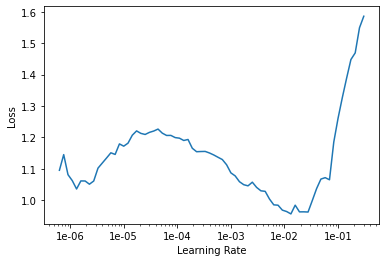

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(20,max_lr=5.13e-03)

epoch,train_loss,valid_loss,error_rate,time
0,1.013423,0.579039,0.234818,00:27
1,0.810195,0.277585,0.101215,00:28
2,0.615909,0.404716,0.137652,00:28
3,0.585606,0.486619,0.145749,00:27
4,0.591878,0.362213,0.149798,00:28
5,0.459692,0.263899,0.093117,00:28
6,0.384271,0.469642,0.133603,00:28
7,0.387799,0.210558,0.089069,00:26
8,0.359694,0.380335,0.109312,00:28
9,0.313287,0.263419,0.105263,00:27


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [12]:
preds = learn.get_preds(ds_type=DatasetType.Test)
print(preds[0].shape)
preds[0]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

torch.Size([249, 2])


tensor([[9.9988e-01, 1.1726e-04],
        [4.9221e-02, 9.5078e-01],
        [9.9926e-01, 7.4346e-04],
        [4.7606e-04, 9.9952e-01],
        [9.9928e-01, 7.1857e-04],
        [4.2261e-02, 9.5774e-01],
        [5.8660e-04, 9.9941e-01],
        [1.7130e-05, 9.9998e-01],
        [9.9969e-01, 3.1183e-04],
        [9.8557e-01, 1.4427e-02],
        [2.0927e-01, 7.9073e-01],
        [3.0602e-04, 9.9969e-01],
        [9.9974e-01, 2.5689e-04],
        [9.9949e-01, 5.1345e-04],
        [9.9998e-01, 2.2010e-05],
        [9.9989e-01, 1.1378e-04],
        [9.9991e-01, 9.2120e-05],
        [3.6631e-03, 9.9634e-01],
        [6.2798e-05, 9.9994e-01],
        [9.9609e-01, 3.9068e-03],
        [6.1768e-05, 9.9994e-01],
        [9.9986e-01, 1.3938e-04],
        [6.9388e-04, 9.9931e-01],
        [2.4134e-05, 9.9998e-01],
        [9.9999e-01, 9.9917e-06],
        [1.3638e-03, 9.9864e-01],
        [3.6119e-04, 9.9964e-01],
        [9.7981e-01, 2.0185e-02],
        [9.9992e-01, 8.4336e-05],
        [1.767

In [13]:
classIndices = np.asarray(np.argmax(preds[0],axis=1))

In [29]:
predicted = []
for classIndex in classIndices:
    predicted.append(data.classes[classIndex])

In [30]:
y = []

for label in data.test_ds.items:
    y.append(str(label))

labelPattern = re.compile("([a-z]+)[0-9]+")

y = [labelPattern.search(y[i]).group(1) for i in range(len(y))]

In [31]:
confusionMatrix = confusion_matrix(y,predicted)
print(confusionMatrix)

[[118   8]
 [  3 120]]


In [33]:
right = 0

for row in range(len(confusionMatrix)):
    for col in range(len(confusionMatrix)):
        if (row==col):
            right += confusionMatrix[row,col]

In [36]:
accuracy = right/sum(sum(confusionMatrix))
accuracy

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


'glass'

In [24]:
import pickle
learn.export(os.path.abspath('export.pkl'))

In [35]:
from fastai.vision import *
import torchvision.transforms as T
import tensorflow as tf
def predict(filename):
  classes = ['glass','plastic']
  img_pil = PIL.Image.open(filename)
  img_tensor = T.ToTensor()(img_pil)
  img_fastai = Image(img_tensor)
  learn.export()
  p = learn.predict(img_fastai)
  classIndices = np.asarray(np.argmax(p[2]))
  predicted = []
  predicted.append(classes[classIndices])
  return predicted[0]

In [26]:
import pickle
learn = load_learner("/content/gdrive/MyDrive/Capstone/Image Classifier")
!pip install flask_ngrok
from flask import Flask,request
from flask_ngrok import run_with_ngrok

app = Flask(__name__) 
run_with_ngrok(app) 

@app.route("/",methods=["POST"]) 
def hello():
  file = request.files['file']
  content  = file.read()
  filename = "photo.jpg"
  f = open(filename,"wb")
  f.write(content)
  f.close()
  return predict(filename)


if __name__ == "__main__": 
  app.run()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


'glass'